## Weight shape is <i><b>out_ch × in_ch × k_h × k_w</b></i> 

In [1]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3)
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [5]:
from torchvision import datasets
from torchvision import transforms

data_path = '../data-unversioned/p1ch7/'
cifar10 = datasets.CIFAR10(data_path, train=True)
cifar10_val = datasets.CIFAR10(data_path, train=False)
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
           for img, label in cifar10
           if label in [0, 2]]
cifar2_val = [(img, label_map[label])
            for img, label in cifar10_val
            if label in [0, 2]]

transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                        (0.2470, 0.2435, 0.2616))
])

cifar2 = [(transf(img), label) for img, label in cifar2]
cifar2_val = [(transf(img), label) for img, label in cifar2_val]

In [6]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

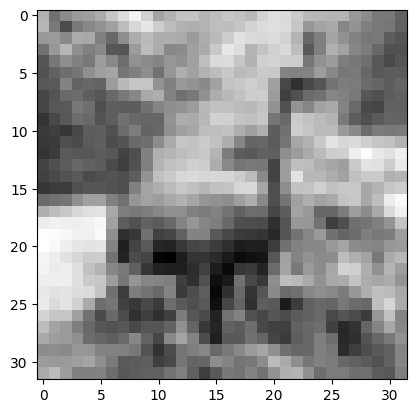

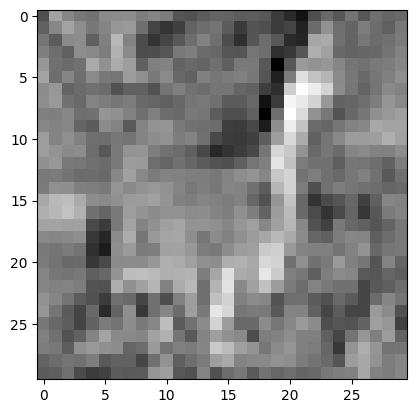

In [11]:
import matplotlib.pyplot as plt

plt.subplot()
plt.imshow(img.mean(0), cmap='gray')
plt.show()
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [13]:
import torch.nn.functional as F
import torch

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [16]:
model = Net()

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

In [17]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [18]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop( 100, optimizer, model, loss_fn, train_loader)

2024-12-08 20:28:45.973082 Epoch 1, Training loss 0.5671120749157705
2024-12-08 20:29:07.990504 Epoch 10, Training loss 0.3368056264652568
2024-12-08 20:29:31.171898 Epoch 20, Training loss 0.29244950802842523
2024-12-08 20:29:56.211028 Epoch 30, Training loss 0.26956492823779965
2024-12-08 20:30:20.859051 Epoch 40, Training loss 0.24838657482604312
2024-12-08 20:30:45.369823 Epoch 50, Training loss 0.22865055724503888
2024-12-08 20:31:10.709544 Epoch 60, Training loss 0.21231036353263127
2024-12-08 20:31:36.064272 Epoch 70, Training loss 0.19530981850282403
2024-12-08 20:32:02.406178 Epoch 80, Training loss 0.18082935424746982
2024-12-08 20:32:27.572813 Epoch 90, Training loss 0.16628845304155807
2024-12-08 20:32:54.054766 Epoch 100, Training loss 0.15138838468653382


In [19]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name , correct / total))

In [20]:
validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


In [22]:
torch.save(model.state_dict(), '/Users/shahdelrefai/HandsOnPytorch/CIFAR-10/' + 'birds_vs_airplanes.pt')

In [23]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load('/Users/shahdelrefai/HandsOnPytorch/CIFAR-10/' + 'birds_vs_airplanes.pt'))

/var/folders/fz/20cl8zx17_g5rwwjnhb46z280000gn/T/ipykernel_41540/642851715.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('/User

<All keys matched successfully>

In [36]:
device = (torch.device('mps')
                )
print(f"Training on device {device}.")

Training on device mps.


In [37]:
import time

# GPU
start_time = time.time()

# syncrocnize time with cpu, otherwise only time for oflaoding data to gpu would be measured
torch.mps.synchronize()

a = torch.ones(4000,4000, device="mps")
for _ in range(200):
   a +=a

elapsed_time = time.time() - start_time
print( "GPU Time: ", elapsed_time)

GPU Time:  0.4409458637237549


# Helping our model to converge and generalize: Regularization

## Weight decay : L2 regularization

the sum of squares of all weights in the model, scaled by a small factor lamda(weight decay)</br>
`- 2 * lambda * w_i`</br>
adding L2 regularization to the loss function is equivalent to decreasing each weight by an amount proportional to its current value during the optimization step

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))